In [1]:
import pandas as pd
import numpy as np
from numpy import nan
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import matplotlib.pyplot as plt 
import seaborn as sns
import time
import datetime
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ori = pd.read_csv(r'F:\CSE 6242\Project\Data_TimeSeries.csv')
df_ori.head()

,Date,Name,Code,Visit
0,1979-01-01,Acadia NP,ACAD,6011
1,1979-02-01,Acadia NP,ACAD,5243
2,1979-03-01,Acadia NP,ACAD,11165
3,1979-04-01,Acadia NP,ACAD,219351
4,1979-05-01,Acadia NP,ACAD,339416


In [3]:
df_ori.shape

(28115, 4)

## Remove 8 parks which has smaller time step

In [4]:
check_shape = (df_ori.groupby("Name").size() == 516)
check_shape

to_delete = ["Channel Islands NP", "Congaree NP", "Gates of the Arctic NP & PRES", "Katmai NP & PRES", "Kenai Fjords NP",
              "Kobuk Valley NP", "Lake Clark NP & PRES", "Wrangell-St. Elias NP & PRES"]
df = df_ori[~df_ori.stack().explode().isin(to_delete).any(level=0)]
df.shape

(24252, 4)

In [5]:
# Convert Date from object to Date type
df['Date'] = pd.to_datetime(df['Date'])
# set Date as index
df = df.set_index(df.Date)
# Drop Date column
df.drop('Date', axis= 1, inplace= True)
df.head()

,Name,Code,Visit
Date,,,
1979-01-01,Acadia NP,ACAD,6011
1979-02-01,Acadia NP,ACAD,5243
1979-03-01,Acadia NP,ACAD,11165
1979-04-01,Acadia NP,ACAD,219351
1979-05-01,Acadia NP,ACAD,339416


In [6]:
df.Name.nunique()

47

## 1. Test the Stationary of the data
Results shows that the data has trend and seasonaility (and therefore is not stationary) as the mean and standard deviation varies with time.

In [7]:
df1 = df.groupby(df.index).mean()
# df1

Results of Dickey-Fuller Test:
Test Statistic                  -1.669588
p-value                          0.446846
#Lags Used                      14.000000
Number of Observations Used    501.000000
Critical Value (1%)             -3.443470
Critical Value (5%)             -2.867326
Critical Value (10%)            -2.569852
dtype: float64


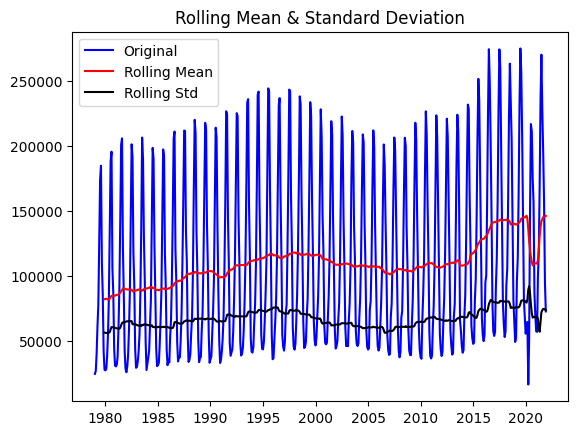

In [8]:
def stationarity(timeseries):
    # Determing rolling statistics for a period of 12 months
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color= 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color ='black', label = 'Rolling Std')
    plt.legend()

    plt.title('Rolling Mean & Standard Deviation')
        
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
stationarity(df1)    
plt.savefig(r"F:\CSE 6242\Project\Viz\Rolling.png", dpi = 300)

## 2. Seasonality Plot

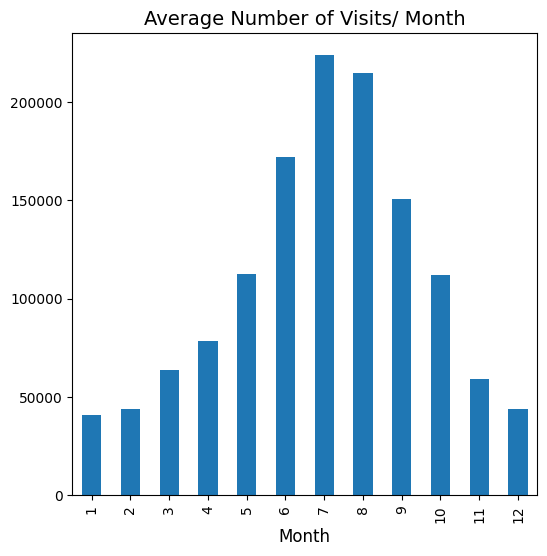

In [20]:
df1.groupby(df1.index.month)['Visit'].mean().plot.bar(figsize= (6, 6))
plt.title("Average Number of Visits/ Month", fontsize = 14)
plt.xlabel("Month", fontsize = 12)

plt.savefig(r"F:\CSE 6242\Project\Viz\Month.png", dpi = 300)

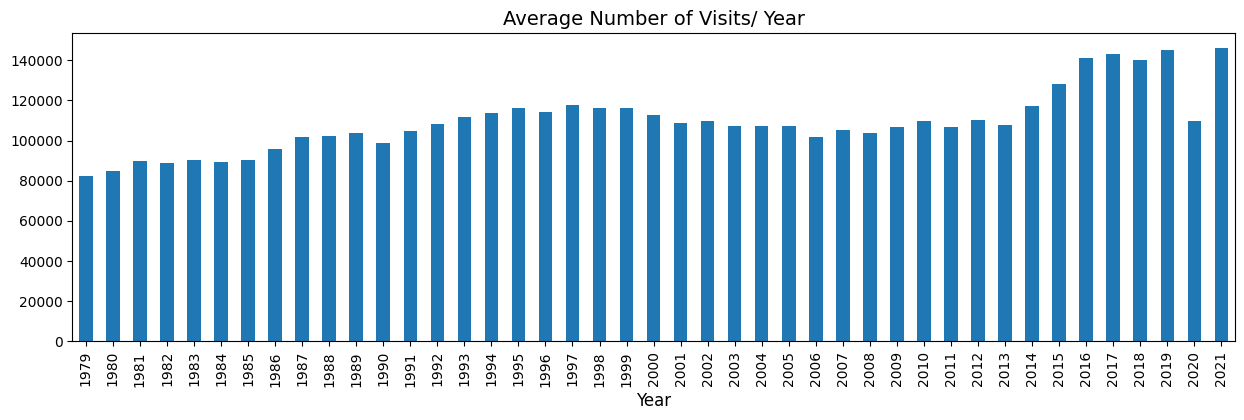

In [13]:
df1.groupby(df1.index.year)['Visit'].mean().plot.bar(figsize= (15, 4))
plt.title("Average Number of Visits/ Year", fontsize = 14)
plt.xlabel("Year", fontsize = 12)
plt.savefig(r"F:\CSE 6242\Project\Viz\Year.png", dpi = 300)

# 1. ARIMA model with Sesonality

In this model, we will force the recent seasonality into the traning and use it for forecast

In [14]:
df2 = df.drop(["Code"], axis = 1)

In [15]:
# Compute Seasonal Index

# multiplicative seasonal component: 36 months for 3 years
season_mul = seasonal_decompose(df2['Visit'][-36:],   
                                model = 'multiplicative', 
                                extrapolate_trend = 'freq')

seasonal_index = season_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base df2
df2['month'] = df2.index.month
df3 = pd.merge(df2, seasonal_index, how= 'left', on= 'month')
df3.columns = ['Name','value', 'month', 'seasonal_index']
df3.index = df2.index  # reassign the index.
df3.shape
df3.to_csv(r"F:\CSE 6242\Project\Data_Final.csv")

In [16]:
df3.head()
df3.Name.unique()

array(['Acadia NP', 'Arches NP', 'Badlands NP', 'Big Bend NP',
       'Biscayne NP', 'Black Canyon of the Gunnison NP',
       'Bryce Canyon NP', 'Canyonlands NP', 'Capitol Reef NP',
       'Carlsbad Caverns NP', 'Crater Lake NP', 'Cuyahoga Valley NP',
       'Death Valley NP', 'Denali NP & PRES', 'Dry Tortugas NP',
       'Everglades NP', 'Glacier Bay NP & PRES', 'Glacier NP',
       'Grand Canyon NP', 'Grand Teton NP', 'Great Basin NP',
       'Great Sand Dunes NP & PRES', 'Great Smoky Mountains NP',
       'Guadalupe Mountains NP', 'Haleakala NP', 'Hawaii Volcanoes NP',
       'Hot Springs NP', 'Isle Royale NP', 'Joshua Tree NP',
       'Lassen Volcanic NP', 'Mammoth Cave NP', 'Mesa Verde NP',
       'Mount Rainier NP', 'North Cascades NP', 'Olympic NP',
       'Petrified Forest NP', 'Pinnacles NP', 'Redwood NP',
       'Rocky Mountain NP', 'Saguaro NP', 'Shenandoah NP',
       'Theodore Roosevelt NP', 'Voyageurs NP', 'Wind Cave NP',
       'Yellowstone NP', 'Yosemite NP', 'Zion NP'

In [17]:
## Training dataset
df4 = df3[df3.index <= "2018-12-01"]
# df4.tail()
# df4.shape

## Tunning optimal parameters for ARIMA model 

In [18]:
df4.Name.unique()

array(['Acadia NP', 'Arches NP', 'Badlands NP', 'Big Bend NP',
       'Biscayne NP', 'Black Canyon of the Gunnison NP',
       'Bryce Canyon NP', 'Canyonlands NP', 'Capitol Reef NP',
       'Carlsbad Caverns NP', 'Crater Lake NP', 'Cuyahoga Valley NP',
       'Death Valley NP', 'Denali NP & PRES', 'Dry Tortugas NP',
       'Everglades NP', 'Glacier Bay NP & PRES', 'Glacier NP',
       'Grand Canyon NP', 'Grand Teton NP', 'Great Basin NP',
       'Great Sand Dunes NP & PRES', 'Great Smoky Mountains NP',
       'Guadalupe Mountains NP', 'Haleakala NP', 'Hawaii Volcanoes NP',
       'Hot Springs NP', 'Isle Royale NP', 'Joshua Tree NP',
       'Lassen Volcanic NP', 'Mammoth Cave NP', 'Mesa Verde NP',
       'Mount Rainier NP', 'North Cascades NP', 'Olympic NP',
       'Petrified Forest NP', 'Pinnacles NP', 'Redwood NP',
       'Rocky Mountain NP', 'Saguaro NP', 'Shenandoah NP',
       'Theodore Roosevelt NP', 'Voyageurs NP', 'Wind Cave NP',
       'Yellowstone NP', 'Yosemite NP', 'Zion NP'

In [19]:
df4.Name.unique()
mask = (df4.Name == 'Crater Lake NP') 
df5 = df4[mask]

In [276]:
n_periods = 61 # for 5 years (n_periods = 61)
i = 0

Predicted_Visit = pd.DataFrame()
All_Parks = pd.DataFrame()

for parkname in (df5.Name.unique()):
    
    sxmodel = pm.auto_arima(df5.iloc[516*i:516*(i+1),:][['value']], exogenous= df5.iloc[516*i:516*(i+1),:][['seasonal_index']],
                           start_p = 1, start_q = 1,
                           test = 'adf',
                           max_p = 2, max_q = 2, m = 12,
                           start_P = 0, seasonal = True,
                           d = None, D = 1, trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True)
    
    # Forecast for 5 years (n_periods = 61)
    
    fitted, confint = sxmodel.predict(n_periods = n_periods, 
                                      exogenous = np.tile(seasonal_index.values, 2).reshape(-1,1), 
                                      return_conf_int = True)

    index_of_fc = pd.date_range(df5.index[-1], periods = n_periods, freq= 'MS')
    
    # Make series 
    fitted_series = pd.Series(fitted, index = index_of_fc)
    lower_series = pd.Series(confint[:, 0], index = index_of_fc)
    upper_series = pd.Series(confint[:, 1], index = index_of_fc)    
    
    #Creating a dictionary by passing Series objects as values
    frame = {'Name': parkname, 'Visit': fitted_series, "UCI": upper_series, "LCI" : lower_series}
    
    result = pd.DataFrame(frame)
    
#     Predicted_Visit = Predicted_Visit.append(result)
    result.dropna(inplace = True)  

    result.to_csv("F:\\CSE 6242\\Project\\output\\" +str(parkname)+".csv")
                          
    i += 1

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=10063.275, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10131.645, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10087.547, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10072.688, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10131.195, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=10123.753, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=10058.043, Time=0.63 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=10087.944, Time=0.38 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=10058.525, Time=1.90 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=10058.130, Time=1.74 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=10056.139, Time=1.13 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=10065.633, Time=1.29 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=10055.858, Time=0.94 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=10062.887, Time=0.26 sec
 ARIM